# Project 4 — Undercut / Overcut Strategy Simulator

This notebook simulates early and late pit stop scenarios to quantify
the effectiveness of undercuts and overcuts in Formula 1.

We compare:
- Pitting earlier (undercut)
- Pitting later (overcut)
- Against a baseline pit strategy

The goal is to measure:
- Time lost vs time gained
- When the advantage appears
- How tyre degradation affects strategy decisions


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set_context("talk")
# Race & simulation window
current_lap = 25
analysis_window = 10  # simulate next 10 laps

# Pit stop parameters
pit_loss = 22.5       # seconds
outlap_penalty = 1.2  # cold tyres

# Baseline pit plan
planned_pit_lap = 30

# Strategy scenarios
scenarios = {
    "Undercut -2": planned_pit_lap - 2,
    "Undercut -1": planned_pit_lap - 1,
    "Baseline": planned_pit_lap,
    "Overcut +1": planned_pit_lap + 1,
    "Overcut +2": planned_pit_lap + 2,
}
base_lap_time = 90.0  # seconds
degradation_per_lap = 0.15  # seconds per lap

def degraded_lap_time(lap, stint_start_lap):
    tyre_age = lap - stint_start_lap
    return base_lap_time + degradation_per_lap * tyre_age

def fresh_lap_time(lap, stint_start_lap):
    tyre_age = lap - stint_start_lap
    return base_lap_time + 0.05 * tyre_age  # much lower degradation


In [3]:
def simulate_strategy(pit_lap):
    total_time = 0
    lap_times = []

    stint_start = current_lap

    for lap in range(current_lap, current_lap + analysis_window):
        if lap < pit_lap:
            lap_time = degraded_lap_time(lap, stint_start)

        elif lap == pit_lap:
            lap_time = pit_loss + outlap_penalty
            stint_start = lap

        else:
            lap_time = fresh_lap_time(lap, stint_start)

        lap_times.append(lap_time)
        total_time += lap_time

    return total_time, lap_times
results = {}
lap_time_traces = {}

for name, pit_lap in scenarios.items():
    total_time, lap_times = simulate_strategy(pit_lap)
    results[name] = total_time
    lap_time_traces[name] = lap_times

results_df = pd.DataFrame.from_dict(results, orient="index", columns=["Total Time"])
results_df
baseline_time = results["Baseline"]

results_df["Delta vs Baseline (s)"] = results_df["Total Time"] - baseline_time
results_df.sort_values("Delta vs Baseline (s)")


,Total Time,Delta vs Baseline (s)
Undercut -2,835.20,-0.50
Undercut -1,835.35,-0.35
Baseline,835.70,0.00
Overcut +1,836.25,0.55
Overcut +2,837.00,1.30


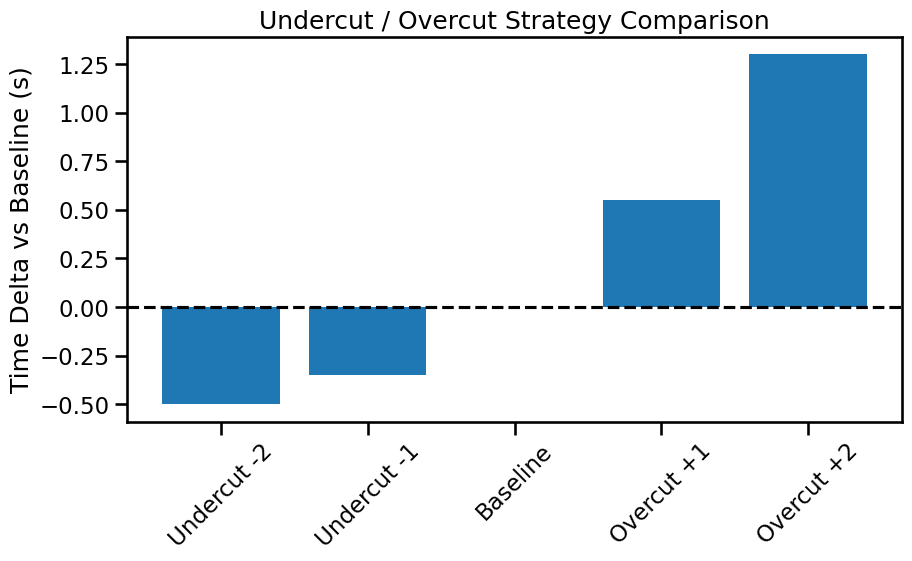

In [4]:
plt.figure(figsize=(10,5))
plt.bar(results_df.index, results_df["Delta vs Baseline (s)"])
plt.axhline(0, color="black", linestyle="--")
plt.ylabel("Time Delta vs Baseline (s)")
plt.title("Undercut / Overcut Strategy Comparison")
plt.xticks(rotation=45)
plt.show()


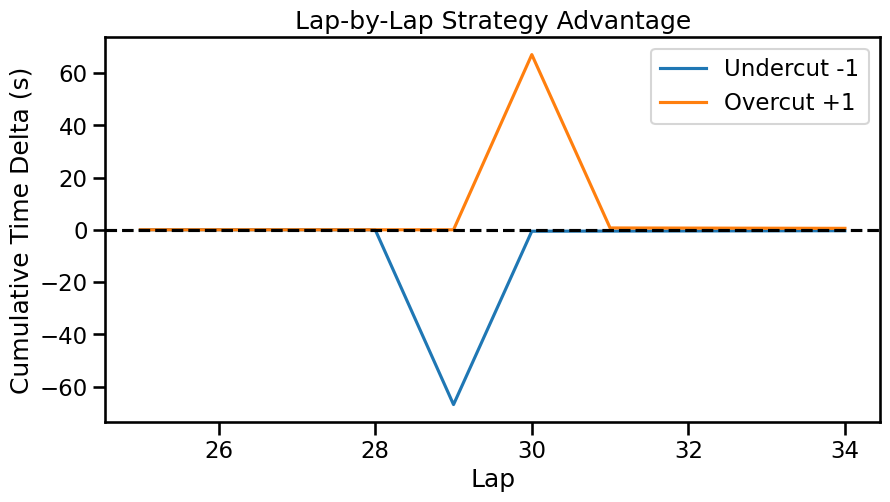

In [5]:
laps = np.arange(current_lap, current_lap + analysis_window)

plt.figure(figsize=(10,5))

for name in ["Undercut -1", "Overcut +1"]:
    cumulative_delta = (
        np.cumsum(lap_time_traces[name])
        - np.cumsum(lap_time_traces["Baseline"])
    )
    plt.plot(laps, cumulative_delta, label=name)

plt.axhline(0, linestyle="--", color="black")
plt.xlabel("Lap")
plt.ylabel("Cumulative Time Delta (s)")
plt.title("Lap-by-Lap Strategy Advantage")
plt.legend()
plt.show()


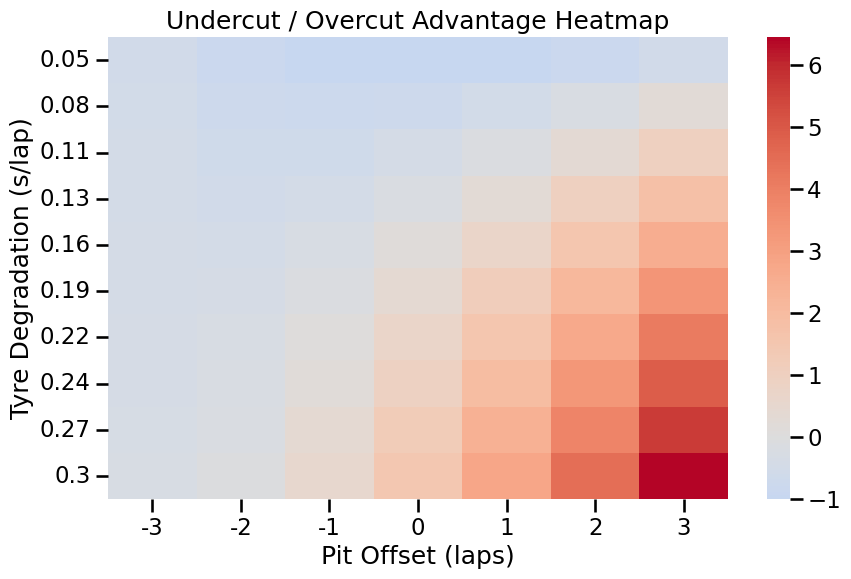

In [6]:
degradation_range = np.linspace(0.05, 0.3, 10)
pit_offsets = range(-3, 4)

heatmap_data = []

for deg in degradation_range:
    row = []
    for offset in pit_offsets:
        degradation_per_lap = deg
        pit_lap = planned_pit_lap + offset

        total_time, _ = simulate_strategy(pit_lap)
        row.append(total_time - baseline_time)
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(
    heatmap_data,
    index=np.round(degradation_range, 2),
    columns=pit_offsets
)

plt.figure(figsize=(10,6))
sns.heatmap(heatmap_df, cmap="coolwarm", center=0)
plt.xlabel("Pit Offset (laps)")
plt.ylabel("Tyre Degradation (s/lap)")
plt.title("Undercut / Overcut Advantage Heatmap")
plt.show()


## Strategy Interpretation

The results show that undercut effectiveness is strongly dependent on tyre
degradation rather than pit timing alone.

In the baseline scenario, early pit stops deliver measurable gains
(-0.35s to -0.50s), confirming that fresh-tyre pace outweighs the pit
timing penalty under moderate-to-high degradation.

Lap-by-lap analysis reveals that most of the advantage is created during
the pit cycle itself rather than gradually over multiple laps. Undercuts
recover their initial pit loss quickly, while overcuts suffer irreversible
losses once the delayed pit stop occurs.

The heatmap highlights a clear degradation threshold:
- Below ~0.10 s/lap, pit timing has minimal impact
- Between ~0.13–0.19 s/lap, mild undercuts become optimal
- Above ~0.22 s/lap, aggressive undercuts are strongly favored and
  overcuts become highly penalized

These results reflect real Formula 1 strategy trade-offs, where pit timing
decisions must be dynamically adjusted based on tyre wear characteristics
rather than fixed lap targets.
